## Spark Explore Exercises

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

spark = pyspark.sql.SparkSession.builder.getOrCreate()

import explore

In [2]:
# Bring the data in...
# read in CSV for cases
cases_df = spark.read.csv('case.csv',
                          header=True,
                          inferSchema=True)

# read in CSV for departments
depts_df = spark.read.csv('dept.csv',
                          header=True,
                          inferSchema=True)

# read in CSV for sources
srces_df = spark.read.csv('source.csv',
                          header=True,
                          inferSchema=True)

# join DataFrames into one
df = cases_df.join(depts_df, 'dept_division', 'left')\
             .join(srces_df, 'source_id', 'left')

# rename column for improved clarity
df = df.withColumnRenamed('SLA_due_date', 'case_due_date')

# convert to appropriate data types
df = df.withColumn('case_late', col('case_late') == 'YES')\
       .withColumn('case_closed', col('case_closed') == 'YES')
# set datetime format
date_fmt = 'M/d/yy H:mm'
df = df.withColumn('case_opened_date',
                   to_timestamp(col('case_opened_date'),
                   date_fmt))\
       .withColumn('case_closed_date',
                   to_timestamp(col('case_closed_date'),
                   date_fmt))\
       .withColumn('case_due_date',
                   to_timestamp(col('case_due_date'),
                   date_fmt))

# create column for case_lifetime
df = df.withColumn('case_age',
                   datediff(current_timestamp(),'case_opened_date'))\
       .withColumn('days_to_closed',
                   datediff('case_closed_date', 'case_opened_date'))\
       .withColumn('case_lifetime',
                   when(col('case_closed'),
                        col('days_to_closed')).otherwise(col('case_age')))\
       .drop('case_age', 'days_to_closed')

In [3]:
df.show(3, False, True)

-RECORD 0-------------------------------------------------------
 source_id              | svcCRMLS                              
 dept_division          | Field Operations                      
 case_id                | 1014127332                            
 case_opened_date       | 2018-01-01 00:42:00                   
 case_closed_date       | 2018-01-01 12:29:00                   
 case_due_date          | 2020-09-26 00:42:00                   
 case_late              | false                                 
 num_days_late          | -998.5087616000001                    
 case_closed            | true                                  
 service_request_type   | Stray Animal                          
 SLA_days               | 999.0                                 
 case_status            | Closed                                
 request_address        | 2315  EL PASO ST, San Antonio, 78207  
 council_district       | 5                                     
 dept_name              |

1. How many different cases are there, by department?

In [4]:
all_cases = (
    df.groupby('case_id')
    .count()
    .sort(col('count').desc())
    .show(100, False)
)

+----------+-----+
|case_id   |count|
+----------+-----+
|1014484191|4    |
|1013624603|4    |
|1013337553|3    |
|1014441510|2    |
|1014334917|2    |
|1013338269|2    |
|1014387863|2    |
|1013892742|2    |
|1014485338|2    |
|1014329608|2    |
|1013291587|2    |
|1014618059|2    |
|1014135118|2    |
|1013876173|2    |
|1013332191|2    |
|1014379812|2    |
|1014381208|2    |
|1014384578|2    |
|1013693732|2    |
|1014391588|2    |
|1014414732|2    |
|1014161951|2    |
|1013303617|2    |
|1014282308|2    |
|1014392643|2    |
|1013814057|2    |
|1013316612|2    |
|1014281566|2    |
|1014625125|2    |
|1014645531|2    |
|1014677129|2    |
|1014717420|2    |
|1013257998|2    |
|1013268287|2    |
|1013726960|2    |
|1013291613|2    |
|1013298968|2    |
|1013300761|2    |
|1013306384|2    |
|1013307469|2    |
|1014334937|2    |
|1014280287|2    |
|1014363240|2    |
|1014133964|2    |
|1013309827|2    |
|1014138381|2    |
|1014365846|2    |
|1014392380|2    |
|1014440028|2    |
|1013739597|

In [5]:
(
    df.filter(df.case_id == 1014139909)
    .show(10, False, True)
)

-RECORD 0------------------------------------------------------
 source_id              | 138650                               
 dept_division          | Miscellaneous                        
 case_id                | 1014139909                           
 case_opened_date       | 2018-01-05 19:15:00                  
 case_closed_date       | 2018-01-06 09:29:00                  
 case_due_date          | 2018-01-07 19:15:00                  
 case_late              | false                                
 num_days_late          | -1.4070949069999998                  
 case_closed            | true                                 
 service_request_type   | Dead Animal - Dog                    
 SLA_days               | 2.0                                  
 case_status            | Closed                               
 request_address        | 2120  TAMPICO ST, San Antonio, 78207 
 council_district       | 5                                    
 dept_name              | Solid Waste Ma

In [6]:
# Group by dept
# agg function to get the sum of cases

(
    df.groupby('dept_name')
    .count()
    .sort(col('count').desc())
    .show(20, truncate=False)
)

+-------------------------+------+
|dept_name                |count |
+-------------------------+------+
|Code Enforcement Services|321984|
|Solid Waste Management   |286287|
|Animal Care Services     |119362|
|Trans & Cap Improvements |97841 |
|Parks and Recreation     |19964 |
|Metro Health             |5313  |
|Customer Service         |2889  |
|Development Services     |1397  |
|null                     |198   |
|City Council             |34    |
+-------------------------+------+



2. Does the percentage of cases that are late vary by department?

3. On average, how late are the late cases by department?

4. What is the service type that is the most late? Just for Parks & Rec?

5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

6. Does whether or not its a weekend matter for when a case is opened/closed?

7. On average, how many cases are opened a day for the Customer Service department?

In [12]:
# filter to only show Customer Service requests
cases_by_day = (df.filter
    (df.dept_name == 'Customer Service')
    .select(
    "dept_name",
# format our dates to remove time, and just show year/month/day
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
)
               )

In [13]:
# assign a new dataframe from our spark dataframe called cases opened by day
cases_opened_by_day = (
# reference cases by day that we just created
    cases_by_day
# group by case opened date
    .groupby('case_opened_date')
# aggregate by count
    .count()
# drop any null values
    .na.drop()
# sort by the dates    
    .sort('case_opened_date')
# send it to pandas
    .toPandas()
# turn case opened date into a pandas datetime    
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
# set the datetime as our index
    .set_index('case_opened_date')
# reference the count Series in our dataframe
    ['count']
)
cases_opened_by_day.name = 'cases_opened'

In [14]:
# How many cases are opened per day on average in Customer Service
answer = cases_opened_by_day.mean()

print(f'There are an average of {answer:.2} cases opened per day in Customer Service')

There are an average of 5.6 cases opened per day in Customer Service


                        dept   daily_avg
8               City Council    1.214286
0       Development Services    3.111359
1           Customer Service    5.642578
2               Metro Health   11.022822
3       Parks and Recreation   34.599653
4   Trans & Cap Improvements  167.249573
5       Animal Care Services  204.037607
6     Solid Waste Management  489.379487
7  Code Enforcement Services  550.400000


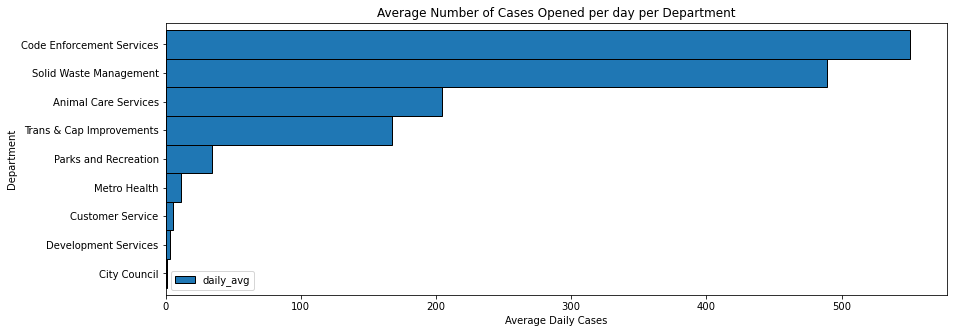

In [10]:
# can I show the average number od cases opened per day in each dept?

# create a list of all departments
dept_list = ['Code Enforcement Services', 
            'Solid Waste Management',
            'Animal Care Services', 
            'Trans & Cap Improvements', 
            'Parks and Recreation',
            'Metro Health',
            'Customer Service', 
            'Development Services',  
            'City Council']

avg_df = pd.DataFrame(columns=['dept', 'daily_avg'])

for dept in dept_list:
    
    # assign a new dataframe from our spark dataframe called cases opened by day
    cases_opened_by_day = (df.filter
    (df.dept_name == dept)
    .select(
    "dept_name",
# format our dates to remove time, and just show year/month/day
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
)
        
     
# group by case opened date
    .groupby('case_opened_date')
# aggregate by count
    .count()
# drop any null values
    .na.drop()
# sort by the dates    
    .sort('case_opened_date')
# send it to pandas
    .toPandas()
# turn case opened date into a pandas datetime    
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
# set the datetime as our index
    .set_index('case_opened_date')
# reference the count Series in our dataframe
    ['count']
)
    cases_opened_by_day.name = 'cases_opened'
    
    answer = cases_opened_by_day.mean() 
    
    avg_df = avg_df.append(
    {
    'dept': dept,
    'daily_avg': answer}, ignore_index=True)
    
    avg_df = avg_df.sort_values(by='daily_avg', ascending=True)
    
avg_df.plot.barh(width=1, edgecolor="black", figsize=(14, 5))
plt.title('Average Number of Cases Opened per day per Department')
plt.xlabel('Average Daily Cases')
plt.ylabel('Department')
plt.yticks(np.arange(9), labels = list(avg_df.dept))


    

print(avg_df)

                        dept   daily_avg
8               City Council    1.214286
0       Development Services    3.111359
1           Customer Service    5.642578
2               Metro Health   11.022822
3       Parks and Recreation   34.599653
4   Trans & Cap Improvements  167.249573
5       Animal Care Services  204.037607
6     Solid Waste Management  489.379487
7  Code Enforcement Services  550.400000


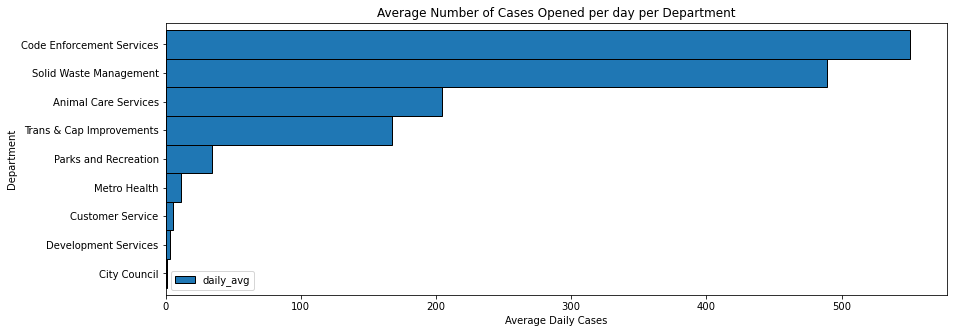

In [11]:
# now let's look at all departments...
explore.avg_daily_openings(df)

8. Does the number of service requests for the solid waste department vary by day of the week?